# K-Means - Semillas

Daniel Ladino

---


In [1]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.impute import SimpleImputer
import nbformat
import os

print('Librerías cargadas correctamente')

Librerías cargadas correctamente


In [2]:
# Cargar dataset
# Intenta cargar 'seeds.csv'
csv_candidates = ['semillas.csv', 'Seeds.csv', 'seeds.csv']

df = None
for fname in csv_candidates:
    if os.path.exists(fname):
        try:
            df = pd.read_csv(fname)
            print(f'Archivo cargado desde: {fname}')
            break
        except Exception as e:
            print(f'Error en lectura de  {fname}: {e}')

if df is None:
    try:
        # En Colab, usar from google.colab import files
        from google.colab import files
        uploaded = files.upload()
        # tomar el primer archivo subido
        first = next(iter(uploaded))
        df = pd.read_csv(first)
        print(f'Archivo cargado: {first}')
    except Exception as e:
        print('Erroe al cargar el archivo. Asegúrate de subir un CSV llamado semillas.csv.')
        raise e

# Mostrar las primeras filas y resumen
print('\n-- Vista previa (5 filas) --')
display(df.head())
print('\n-- Información del dataset --')
print(df.info())

KeyboardInterrupt: 

In [ ]:
# Análisis exploratorio (EDA) rápido
print('Dimensiones del dataset:', df.shape)
print('\nColumnas:')
print(df.columns.tolist())

# Si la última columna parece una etiqueta (por ejemplo 'Class' o 'Etiqueta'), la detectamos
possible_label_cols = [c for c in df.columns if c.lower() in ['class', 'label', 'target', 'tipo']]
if possible_label_cols:
    print('\nColumnas que parecen etiquetas:', possible_label_cols)

# Estadísticos descriptivos
display(df.describe())

# Conteo de nulos
print('\nValores nulos por columna:')
print(df.isnull().sum())

# Si hay columnas no numéricas, mostrar un resumen
non_numeric = df.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric:
    print('\nColumnas no numéricas detectadas:', non_numeric)
    display(df[non_numeric].head())

Dimensiones del dataset: (210, 8)

Columnas:
['area', 'perimeter', 'compactness', 'kernel_length', 'kernel_width', 'asymmetry_coefficient', 'groove_length', 'species']


,area,perimeter,compactness,kernel_length,kernel_width,asymmetry_coefficient,groove_length,species
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,14.847524,14.559286,0.870999,5.628533,3.258605,3.700201,5.408071,1.000000
std,2.909699,1.305959,0.023629,0.443063,0.377714,1.503557,0.491480,0.818448
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000,0.000000
25%,12.270000,13.450000,0.856900,5.262250,2.944000,2.561500,5.045000,0.000000
50%,14.355000,14.320000,0.873450,5.523500,3.237000,3.599000,5.223000,1.000000
75%,17.305000,15.715000,0.887775,5.979750,3.561750,4.768750,5.877000,2.000000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.456000,6.550000,2.000000



Valores nulos por columna:
area                     0
perimeter                0
compactness              0
kernel_length            0
kernel_width             0
asymmetry_coefficient    0
groove_length            0
species                  0
dtype: int64


In [ ]:
# Preprocesamiento: Imputación (si es necesario) y escalamiento
# Trabajaremos con las columnas numéricas únicamente
num_df = df.select_dtypes(include=[np.number]).copy()
print('Columnas numéricas a usar en clustering:', num_df.columns.tolist())

# Imputación simple si existen nulos
if num_df.isnull().any().any():
    imp = SimpleImputer(strategy='median')
    num_df[:] = imp.fit_transform(num_df)
    print('Se imputaron valores nulos con la mediana.')

# Escalamiento
scaler = StandardScaler()
X_scaled = scaler.fit_transform(num_df)
print('Escalamiento completado. Shape:', X_scaled.shape)

Columnas numéricas a usar en clustering: ['area', 'perimeter', 'compactness', 'kernel_length', 'kernel_width', 'asymmetry_coefficient', 'groove_length', 'species']
Escalamiento completado. Shape: (210, 8)


Matriz de correlación:


,area,perimeter,compactness,kernel_length,kernel_width,asymmetry_coefficient,groove_length,species
area,1.000000,0.994341,0.608288,0.949985,0.970771,-0.229572,0.863693,-0.346058
perimeter,0.994341,1.000000,0.529244,0.972422,0.944829,-0.217340,0.890784,-0.327900
compactness,0.608288,0.529244,1.000000,0.367915,0.761635,-0.331471,0.226825,-0.531007
kernel_length,0.949985,0.972422,0.367915,1.000000,0.860415,-0.171562,0.932806,-0.257269
kernel_width,0.970771,0.944829,0.761635,0.860415,1.000000,-0.258037,0.749131,-0.423463
asymmetry_coefficient,-0.229572,-0.217340,-0.331471,-0.171562,-0.258037,1.000000,-0.011079,0.577273
groove_length,0.863693,0.890784,0.226825,0.932806,0.749131,-0.011079,1.000000,0.024301
species,-0.346058,-0.327900,-0.531007,-0.257269,-0.423463,0.577273,0.024301,1.000000


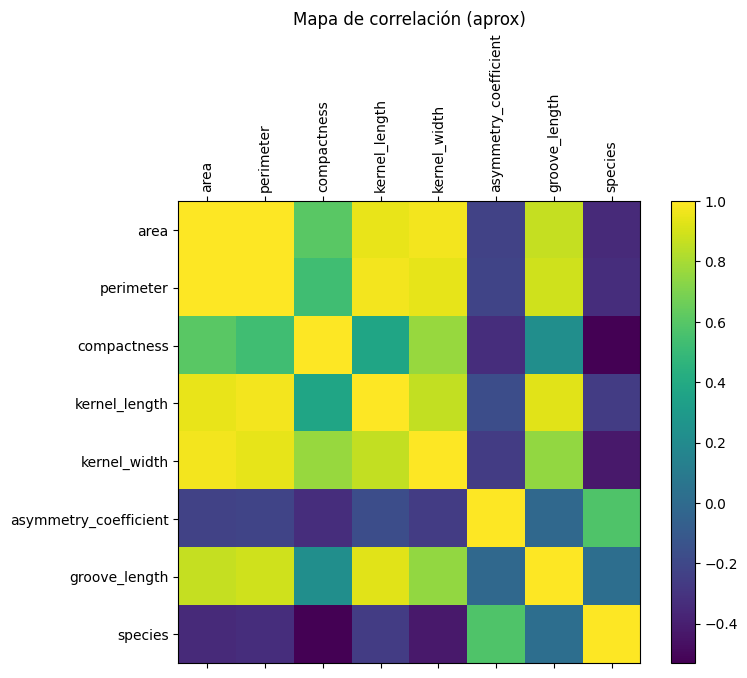

In [ ]:
# Matriz de correlación (visualización con matplotlib)
corr = num_df.corr()
print('Matriz de correlación:')
display(corr)

# Mostrar mapa de calor simple usando matplotlib (sin estilos extras)
fig, ax = plt.subplots(figsize=(8,6))
cax = ax.matshow(corr)
fig.colorbar(cax)
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.columns)
plt.title('Mapa de correlación (aprox)')
plt.show()

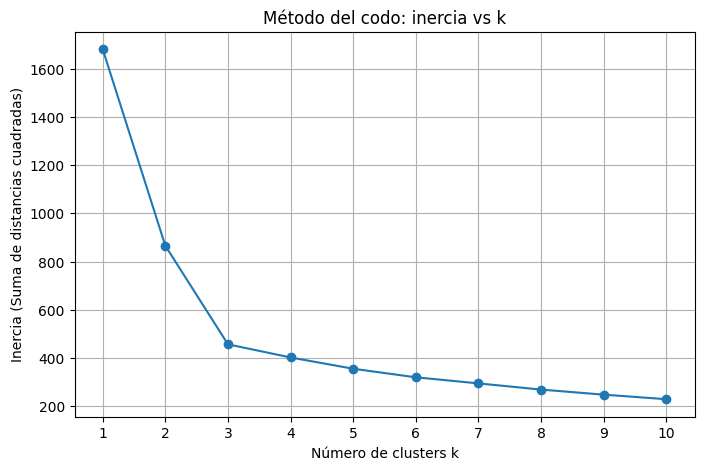

In [ ]:
# Selección de k: Método del codo (inercia)
inertia = []
K = range(1, 11)
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(list(K), inertia, marker='o')
plt.xlabel('Número de clusters k')
plt.ylabel('Inercia (Suma de distancias cuadradas)')
plt.title('Método del codo: inercia vs k')
plt.xticks(list(K))
plt.grid(True)
plt.show()

k=2 -> Silhouette score = 0.4057
k=3 -> Silhouette score = 0.4850
k=4 -> Silhouette score = 0.3895
k=5 -> Silhouette score = 0.3077
k=6 -> Silhouette score = 0.2578
k=7 -> Silhouette score = 0.2537
k=8 -> Silhouette score = 0.2532
k=9 -> Silhouette score = 0.2470
k=10 -> Silhouette score = 0.2593


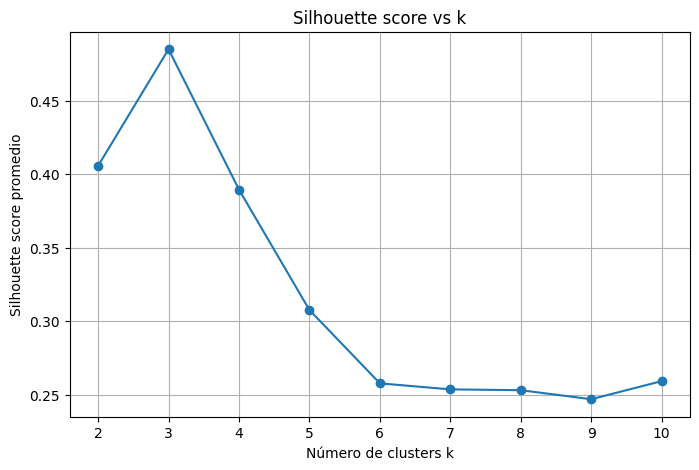

In [ ]:
# Análisis de Silhouette para k entre 2 y 10
from matplotlib import cm
range_n_clusters = list(range(2, 11))
sil_scores = []
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    preds = clusterer.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, preds)
    sil_scores.append(score)
    print(f'k={n_clusters} -> Silhouette score = {score:.4f}')

# Gráfica de silhouette score vs k
plt.figure(figsize=(8,5))
plt.plot(range_n_clusters, sil_scores, marker='o')
plt.xlabel('Número de clusters k')
plt.ylabel('Silhouette score promedio')
plt.title('Silhouette score vs k')
plt.xticks(range_n_clusters)
plt.grid(True)
plt.show()

In [ ]:
# Elegir k y entrenar modelo final
# Sugerencia: elegir k donde la inercia hace "codo" y el silhouette score sea alto.
# Cambia k_final si quieres probar otro valor.
k_final = 3
kmeans = KMeans(n_clusters=k_final, random_state=42, n_init=20)
labels = kmeans.fit_predict(X_scaled)
num_df['Cluster'] = labels

print('Centroides (en espacio escalado):')
display(kmeans.cluster_centers_)

print('\nConteo por cluster:')
display(num_df['Cluster'].value_counts())

Centroides (en espacio escalado):


array([[ 1.21270324,  1.22413366,  0.51723629,  1.20908366,  1.11527789,
        -0.05541116,  1.27193866, -0.03499271],
       [-1.02442616, -1.00658787, -0.91587488, -0.9027431 , -1.07435838,
         0.72547911, -0.59487279,  1.22474487],
       [-0.18827708, -0.21754579,  0.39863859, -0.30634055, -0.04091951,
        -0.67006795, -0.67706587, -1.18975216]])


Conteo por cluster:


,count
Cluster,
2,70
0,70
1,70


Varianza explicada por las componentes principales (cumulativa): [0.64839201 0.86062708]


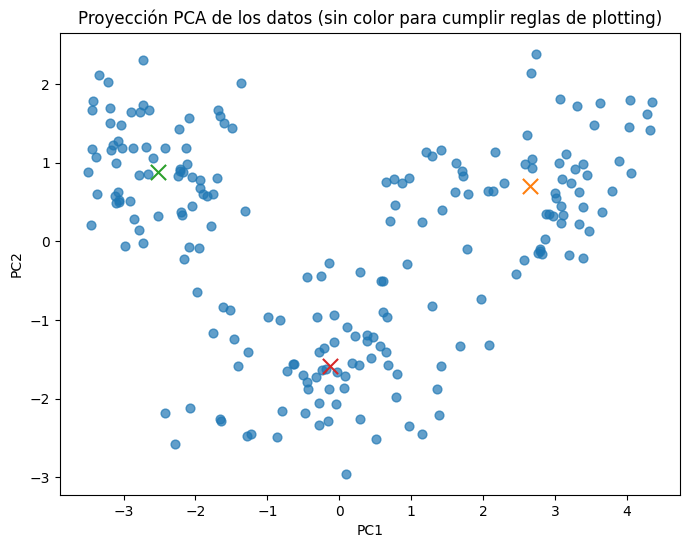

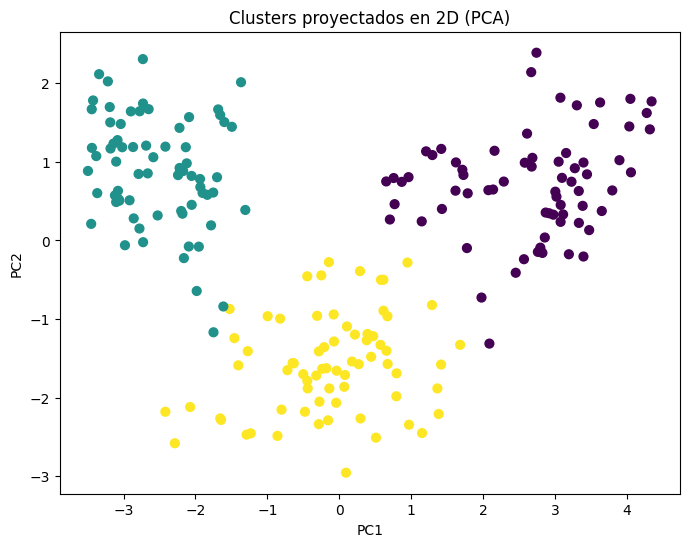

In [ ]:
# Visualización 2D usando PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
explained = pca.explained_variance_ratio_.cumsum()
print('Varianza explicada por las componentes principales (cumulativa):', explained)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], s=40, alpha=0.7)
for c in range(k_final):
    mask = (labels == c)
    plt.scatter(X_pca[mask,0].mean(), X_pca[mask,1].mean(), marker='x', s=120)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Proyección PCA de los datos (sin color para cumplir reglas de plotting)')
plt.show()

# También mostrar componentes con color by cluster (matplotlib default coloring)
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, s=40)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clusters proyectados en 2D (PCA)')
plt.show()

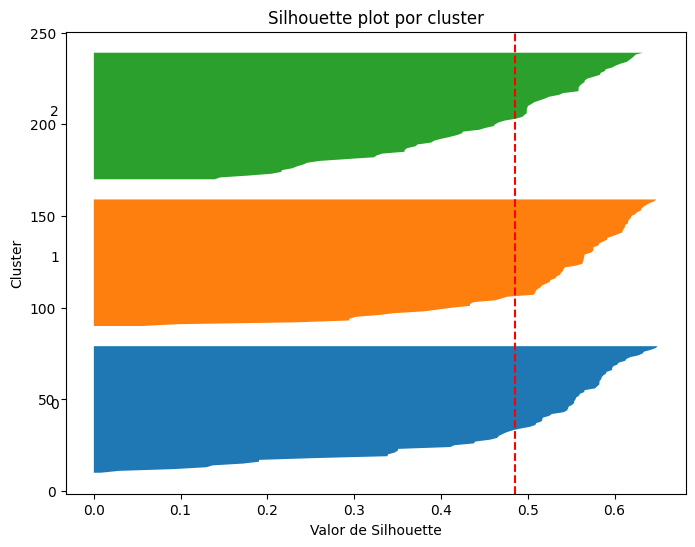

In [ ]:
# Gráfico de Silhouette para k_final
from sklearn.metrics import silhouette_samples
import numpy as np

sample_silhouette_values = silhouette_samples(X_scaled, labels)
y_lower = 10
plt.figure(figsize=(8,6))
for i in range(k_final):
    ith_cluster_sil_values = sample_silhouette_values[labels == i]
    ith_cluster_sil_values.sort()
    size_cluster_i = ith_cluster_sil_values.shape[0]
    y_upper = y_lower + size_cluster_i
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_sil_values)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10  # 10 for spacing between clusters
plt.xlabel('Valor de Silhouette')
plt.ylabel('Cluster')
plt.title('Silhouette plot por cluster')
plt.axvline(x=silhouette_score(X_scaled, labels), color='red', linestyle='--')
plt.show()

In [ ]:
# Perfilado de clusters: centroides en escala original y estadísticas por cluster
centroids_orig = scaler.inverse_transform(kmeans.cluster_centers_)
centroids_df = pd.DataFrame(centroids_orig, columns=num_df.columns[:-1])
centroids_df['Cluster'] = range(centroids_df.shape[0])
print('Centroides (en escala original):')
display(centroids_df.T)

# Estadísticos por cluster (media y std)
profiles = num_df.groupby('Cluster').agg(['mean','std']).T
display(profiles)

Centroides (en escala original):


,0,1,2
area,18.367714,11.873857,14.301000
perimeter,16.154143,13.247857,14.275857
compactness,0.883191,0.849409,0.880396
kernel_length,6.162957,5.229514,5.493129
kernel_width,3.678857,2.853771,3.243186
asymmetry_coefficient,3.617086,4.788400,2.695117
groove_length,6.031714,5.116400,5.076100
species,0.971429,2.000000,0.028571
Cluster,0.000000,1.000000,2.000000


Cluster                             0          1          2
area                  mean  18.367714  11.873857  14.301000
                      std    1.389163   0.723004   1.160495
perimeter             mean  16.154143  13.247857  14.275857
                      std    0.584107   0.340196   0.549916
compactness           mean   0.883191   0.849409   0.880396
                      std    0.015454   0.021760   0.016298
kernel_length         mean   6.162957   5.229514   5.493129
                      std    0.240461   0.138015   0.218779
kernel_width          mean   3.678857   2.853771   3.243186
                      std    0.185179   0.147516   0.174384
asymmetry_coefficient mean   3.617086   4.788400   2.695117
                      std    1.199509   1.336465   1.178744
groove_length         mean   6.031714   5.116400   5.076100
                      std    0.229761   0.162068   0.244806
species               mean   0.971429   2.000000   0.028571
                      std    0.167802   0.000000   0.167802

In [ ]:
# Guardar resultados y exportar
# Adjuntar etiquetas al dataframe original (si tenía columnas no numéricas, las mantenemos)
df_result = df.copy()
df_result.loc[:, 'Cluster'] = labels

# Guardar CSV con clusters
out_csv = 'semillas_con_clusters.csv'
df_result.to_csv(out_csv, index=False)
print(f'Resultados guardados en {out_csv}')

# Además, mostrar primeras filas
display(df_result.head())

Resultados guardados en semillas_con_clusters.csv


,area,perimeter,compactness,kernel_length,kernel_width,asymmetry_coefficient,groove_length,species,Cluster
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,0,2
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,0,2
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,0,2
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,0,2
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,0,2
